In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import mplfinance as mpf

In [3]:
def _display_df(df, nrows=3):
    print(df.head(nrows))
    print("\n",3*"..","\n")
    print(df.tail(nrows))
    
def _reformat_date(df):
    df.rename(columns = {"date_":"Date"},inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date")
    return df

In [4]:
FLAG_DEBUG = False # True # 
NUM_DAYS_QUOTE, NUM_DAYS_PLOT = 390, 250
RSI_PERIOD, RSI_AVG, RSI_BAND_WIDTH = 100, 25, 0.6
EMA_FAST, EMA_SLOW, EMA_LONG = 15, 50, 150
EMA_FAST_SCALE = 1.4  # EMA10 band half-width factor
EMA_SLOW_SCALE = 2.0 
MA_VOL = 20
SPAN, OVERLAP = 200, 15
PANID_PRICE, PANID_VOL, PANID_RSI, PANID_SIGNAL = 0, 3, 2, 1
PANEL_RATIOS = (8, 1, 8, 1)
FIGURE_WIDTH, FIGURE_HEIGHT =  17, 13
YELLOW = '#F5D928'
LIGHT_BLACK = '#8F8E83'

In [5]:
db_name = "NQ100"
file_tickers = "wl_index-QQQ_NASDAQ100.csv"
file_db = f"db_{db_name}.sqlite"
FILE_DB = file_db
file_dict = "ticker-catalog.csv"
CHART_TABLE_NAME = "quote_ta"
ticker = 'QQQ'
date_range = ('20210101', '20220406')

In [6]:
conn = sqlite3.connect(file_db)

In [7]:
select_qqq = f"""
select * from quote_ta where ticker='{ticker}' and 
    date_ between '{date_range[0]}' and '{date_range[1]}' order by date_ ;
"""

sql_cnt_query = f"""
with cnt_total as (
    select date_, count(*) cnt from quote_ta 
        where date_ between '{date_range[0]}' and '{date_range[1]}' group by date_
), cnt_pos as (
    select date_, count(*) cnt from quote_ta 
        where rsi_avg > 0 and date_ between '{date_range[0]}' and '{date_range[1]}' group by date_
), cnt_neg as (
    select date_, count(*) cnt from quote_ta 
        where rsi_avg < 0 and date_ between '{date_range[0]}' and '{date_range[1]}' group by date_
) 
select 
    ct.date_, ct.cnt as "total", cp.cnt as "pos", cn.cnt as "neg", 
	round(100.0*cp.cnt/ct.cnt,1) as "pct_pos", 
	round(100.0*cn.cnt/ct.cnt,1) as "pct_neg"
from cnt_total ct, cnt_pos cp, cnt_neg cn
where ct.date_ = cp.date_ and ct.date_ = cn.date_
;
"""

In [8]:
df_cnt = _reformat_date(pd.read_sql(sql_cnt_query, conn))

In [9]:
df_qqq = _reformat_date(pd.read_sql(select_qqq, conn))

https://stackoverflow.com/questions/20865487/pandas-plot-without-a-legend

array([<AxesSubplot:ylabel='NQ100 Pos(%)'>], dtype=object)

array([<AxesSubplot:ylabel='QQQ'>], dtype=object)

array([<AxesSubplot:ylabel='RSI'>], dtype=object)

array([<AxesSubplot:xlabel='Date', ylabel='Signal'>], dtype=object)

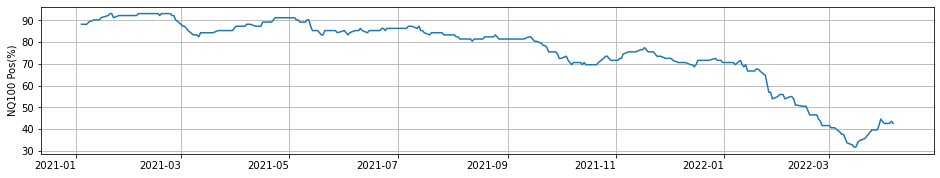

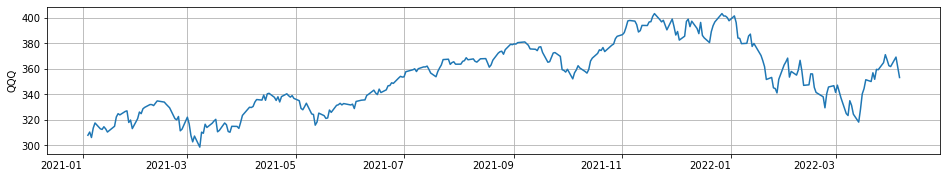

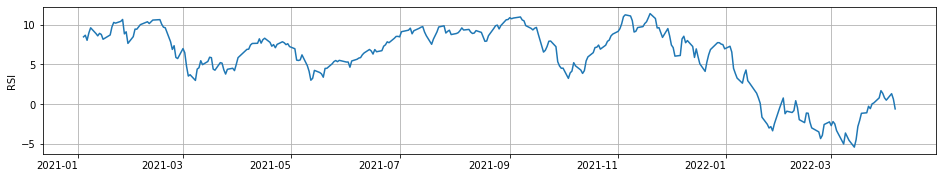

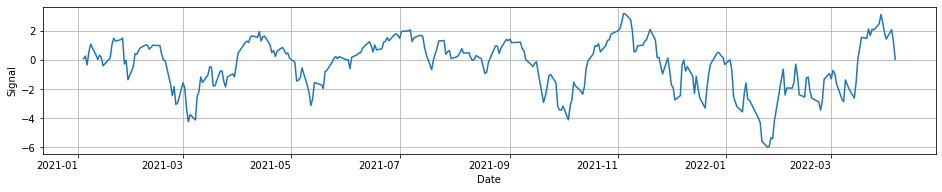

In [10]:
kwargs = {"legend":False,"sharex":True,"subplots":True,"figsize":(16,3),"grid":True}
df_cnt.plot.line(x='Date', y='pct_pos', ylabel=f"{db_name} Pos(%)", rot=0, xlabel='', **kwargs)
df_qqq.plot.line(x='Date', y='close_',ylabel=f"{ticker}",rot=0, xlabel='', **kwargs)
df_qqq.plot.line(x='Date', y='rsi', ylabel="RSI", rot=0, xlabel='', **kwargs)
df_qqq.plot.line(x='Date', y='rsi_signal', rot=0,  ylabel="Signal", **kwargs)